In [1]:
# reference 
# https://www.kaggle.com/code/andreynesterov/monet-cyclegan-with-better-cycles#Generator,-Discriminator-


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=(RuntimeWarning, FutureWarning, UserWarning))

import gc
import time
import os
import urllib.request
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
from io import BytesIO
from matplotlib.pyplot import subplots
import keras
import tensorflow as tf
from keras import layers, Model
from keras.models import Sequential
from keras.layers import Layer, Dense, Activation, Dropout, Input, concatenate, Average, Concatenate, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, LeakyReLU, ZeroPadding2D, GaussianNoise
from keras.optimizers import Adam
from keras.utils import array_to_img
from keras.callbacks import Callback
from keras.initializers import RandomNormal
from keras.losses import BinaryCrossentropy


AUTOTUNE = tf.data.AUTOTUNE

print("OK")

2024-08-20 09:04:33.787755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 09:04:33.788063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 09:04:33.919004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


OK


AUTOTUNE功用:
    
AUTOTUNE 是 TensorFlow 中用于自动调整数据预处理和加载的性能优化工具。它的作用如下：

作用
自动调整并行度： AUTOTUNE 允许 TensorFlow 在数据加载时自动决定最佳的并行度。它会动态调整 num_parallel_calls 的值，以最大化数据预处理的效率。这样可以根据硬件的能力和当前系统负载来优化性能。

提高数据加载速度： 使用 AUTOTUNE 可以在数据预处理和加载过程中提高吞吐量。这意味着在模型训练时，数据加载不会成为瓶颈，从而可以更快地进行训练。

优化缓存和预取： AUTOTUNE 也可以用于优化数据的缓存和预取操作。例如，当使用 .prefetch(AUTOTUNE) 时，TensorFlow 会自动决定预取的最佳数量，以减少模型训练时的等待时间。


# Detect GPU

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f'使用 {len(physical_devices)} 个 GPU 设备')
    for device in physical_devices:
        print(device)
else:
    print('未检测到 GPU，将使用 CPU')

使用 2 个 GPU 设备
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# TPU configuration

In [3]:
#if True:
#    try:
#        resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # 自动连接 TPU
#        tf.config.experimental_connect_to_cluster(resolver)
#        tf.tpu.experimental.initialize_tpu_system(resolver)
#        strategy = tf.distribute.TPUStrategy(resolver)
#        print("on TPU")
#    except (ValueError, tf.errors.NotFoundError) as e:
#        print(f"not on TPU: {e}")
#        strategy = tf.distribute.MirroredStrategy()

#    print("REPLICAS: ", strategy.num_replicas_in_sync)

# Import Outside Function(diffAugment)

In [4]:
url = 'https://raw.githubusercontent.com/mit-han-lab/data-efficient-gans/master/DiffAugment-stylegan2/DiffAugment_tf.py'
filename = 'DiffAugment_tf.py'
urllib.request.urlretrieve(url, filename)
import DiffAugment_tf

function_names = [name for name in dir(DiffAugment_tf) if callable(getattr(DiffAugment_tf, name))]
print("DiffAugment functions:\n", function_names)

DiffAugment functions:
 ['DiffAugment', 'rand_brightness', 'rand_contrast', 'rand_cutout', 'rand_saturation', 'rand_translation']


# Data Collection

In [6]:
if True:
    competition = 'gan-getting-started'
    photo_path_jpg = f"/kaggle/input/{competition}/photo_jpg"
    monet_path_jpg = f"/kaggle/input/{competition}/monet_jpg"
    photo_path_tfrec = f"/kaggle/input/{competition}/photo_tfrec"
    monet_path_tfrec = f"/kaggle/input/{competition}/monet_tfrec"

    photo_files_jpg = tf.io.gfile.glob(f"{photo_path_jpg}/*.jpg")
    monet_files_jpg = tf.io.gfile.glob(f"{monet_path_jpg}/*.jpg")
    photo_files_tfrec = sorted(tf.io.gfile.glob(f"{photo_path_tfrec}/*.tfrec"))
    monet_files_tfrec = sorted(tf.io.gfile.glob(f"{monet_path_tfrec}/*.tfrec"))

In [8]:
photo_files_tfrds = tf.data.TFRecordDataset(photo_files_tfrec)
monet_files_tfrds = tf.data.TFRecordDataset(monet_files_tfrec)
print("OK")

OK


# GPU configuration

In [9]:
if True:
    try:
        # 设定 GPU 策略
        strategy = tf.distribute.MirroredStrategy()
        print("on GPU")
    except Exception as e:
        print(f"GPU setup failed: {e}")
        strategy = tf.distribute.get_strategy()

    print("REPLICAS: ", strategy.num_replicas_in_sync)

on GPU
REPLICAS:  2


# Data Analysis

In [10]:
def count_tfrecord_examples(tfrecords_dir: str,) -> int:
    """
    Counts the total number of examples in a collection of TFRecord files.

    :param tfrecords_dir: directory that is assumed to contain only TFRecord files
    :return: the total number of examples in the collection of TFRecord files
        found in the specified directory
    """
    count = 0
    for file_name in os.listdir(tfrecords_dir):
        tfrecord_path = os.path.join(tfrecords_dir, file_name)
        count += tf.data.TFRecordDataset(tfrecord_path).reduce(np.int64(0), lambda x, _: x + 1)
    return count.numpy()

In [11]:
if True:
    print('Photo .jpg files count:', len(photo_files_jpg))
    print('Monet .jpg files count:', len(monet_files_jpg))

print('Photo .tfrec files count:', len(photo_files_tfrec))

Photo .jpg files count: 7038
Monet .jpg files count: 300
Photo .tfrec files count: 20


# Data visualization

In [12]:
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
def open_and_plot_image(image_path):
    image = Image.open(image_path)
    plot_image(image)
    
def plot_tfrec_image(record, image_feature, extra_features=[]):
    example = tf.train.Example()
    example.ParseFromString(record.numpy())
    image = tf.image.decode_jpeg(
        example.features.feature[image_feature].bytes_list.value[0],
        channels=3
    )
    for feature in extra_features:
        print('Image type:\t', example.features.feature[feature].bytes_list.value[0].decode('utf-8'))
    plot_image(image)

Photo:


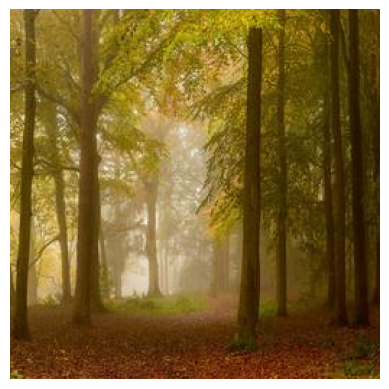

In [13]:
if True:
    print('Photo:')
    open_and_plot_image(os.path.join(photo_path_jpg, photo_files_jpg[0]))

Monet:


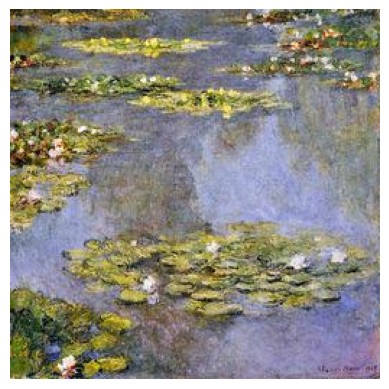

In [14]:
if True:
    print('Monet:')
    open_and_plot_image(os.path.join(monet_path_jpg, monet_files_jpg[0]))

# Visualize .tfrec images

In [15]:
def get_tfrecord_structure(ds):
    record = next(iter(ds.take(1)))
    example = tf.train.Example()
    example.ParseFromString(record.numpy())
    print('TFRecord structure:')
    for feature_key in example.features.feature.keys():
        print(feature_key)

In [16]:
get_tfrecord_structure(monet_files_tfrds)

TFRecord structure:
image_name
target
image


In [17]:
get_tfrecord_structure(photo_files_tfrds)

TFRecord structure:
image
target
image_name


Image type:	 photo
Image type:	 ea626ba3a9


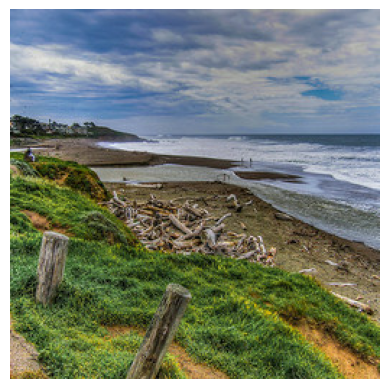

In [18]:
plot_tfrec_image(
    next(iter(photo_files_tfrds.skip(np.random.randint(0,7038)))),
    'image', ['target', 'image_name']
)

Image type:	 monet
Image type:	 2f20944b6a


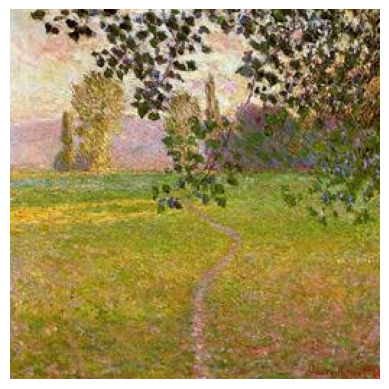

In [19]:
plot_tfrec_image(
    next(iter(monet_files_tfrds.skip(np.random.randint(0,300)))),
    'image', ['target', 'image_name']
)

# EDA Summary

1.Photos dataset has 7038 items

2.Monet dataset has 300 items

3.Image size: 256x256, channels: 3

# Data Preprocessing

In [20]:
if strategy.num_replicas_in_sync == 1:  # 表示只有一個GPU在進行訓練
    BATCH_SIZE = 2
    BUFFER_SIZE = 256
    TEST_BATCH_SIZE_PER_REPLICA = 32
    TEST_BATCH_SIZE = TEST_BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

else:    # 表示有多個設備在訓練
    BATCH_SIZE_PER_REPLICA = 1 #是每个设备的批量大小。在这里设置为 1
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync # 总的批量大小，通过将每个设备的批量大小与设备数量相乘来计算。
    TEST_BATCH_SIZE_PER_REPLICA = 32  # 是每个设备的测试批量大小。在这里设置为 32。
    TEST_BATCH_SIZE = TEST_BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync # 是总的测试批量大小，也通过将每个设备的测试批量大小与设备数量相乘来计算。
    
   #单设备模式：使用固定的批量大小（2），适用于单个 GPU 或 CPU 环境。
  #多设备模式：每个设备使用较小的批量大小（1 或 32），并根据设备的数量调整总批量大小（BATCH_SIZE 和 TEST_BATCH_SIZE）。
  #这种方法确保在多设备环境中，批量大小能在所有设备之间平均分配，同时兼顾了单设备环境的特殊需求。


In [21]:
def decode_image(image):
    """
    功能: 这个函数将 JPEG 编码的图像解码为张量，并进行归一化和调整形状。
    步骤:
        tf.image.decode_jpeg(image, channels=3): 解码 JPEG 图像，并确保图像有 3 个颜色通道（RGB）。
        tf.cast(image, tf.float32) / 127.5) - 1: 将图像像素值从 [0, 255] 归一化到 [-1, 1]。
        tf.reshape(image, shape): 将图像调整为 [256, 256, 3] 的形状。
    """
    shape = [256, 256, 3]
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, shape)
    return image


def read_tfrecord(example):
    """
    功能: 从 TFRecord 文件中读取图像数据，并进行解码和预处理。
    步骤:
        tf.io.parse_single_example(example, tfrecord_format): 将 TFRecord 解析为字典，其中键是特征名称，值是特征的格式。
        decode_image(example['image']): 使用 decode_image 函数对图像进行解码和预处理。
    """
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    """
    功能: 加载 TFRecord 文件并将其转换为 TensorFlow 数据集。
    步骤:
        tf.data.TFRecordDataset(filenames): 创建一个 TFRecord 数据集对象。
        dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE): 使用 read_tfrecord 函数对数据集进行映射，以解码和处理图像。AUTOTUNE 使数据集处理在后台进行自动调整。
    """
    
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def data_augment(image):
    """
    功能: 对图像进行数据增强处理，以提高模型的鲁棒性。
    步骤:
        tf.image.resize(image, [286, 286]): 将图像调整为 [286, 286] 的大小。
        tf.image.random_crop(image, size=[BATCH_SIZE, 256, 256, 3]): 从调整后的图像中随机裁剪出一个 [256, 256, 3] 的区域。BATCH_SIZE 应该是实际的批量大小，通常会设置为一个常数值。
        tf.image.random_flip_left_right(image): 随机左右翻转图像。
    """
    image = tf.image.resize(image, [286, 286])
    image = tf.image.random_crop(image, size=[BATCH_SIZE, 256, 256, 3])
    image = tf.image.random_flip_left_right(image)
    return image

In [22]:
def prepare_gan_ds(photo_files, monet_files, augment_fn=None, repeat=True, shuffle=True, cache=True, batch_size=1):
    
    # 加載數據集
    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    # 緩存數據集,加快數據加載速度
    # 如果 cache 参数为 True，则将数据集缓存到内存中，以加快数据加载速度。
    if cache:
        monet_ds = monet_ds.cache()
        photo_ds = photo_ds.cache()
    
    # 重複數據集
    # 如果 repeat 参数为 True，则重复数据集，确保在训练过程中每个 epoch 都能遍历整个数据集
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    
    
    # 打亂數據集
    # 如果 shuffle 参数为 True，则打乱数据集的顺序。reduce 函数计算数据集的样本数量，并用来进行打乱。
    if shuffle:
        monet_ds_entries = monet_ds.reduce(0, lambda x,_: x+1).numpy()
        photo_ds_entries = photo_ds.reduce(0, lambda x,_: x+1).numpy()
        monet_ds = monet_ds.shuffle(monet_ds_entries)
        photo_ds = photo_ds.shuffle(photo_ds_entries)
    
    # 批量处理数据集
    # 将数据集分批处理，每批的大小由 batch_size 参数指定。
    monet_ds = monet_ds.batch(batch_size)
    photo_ds = photo_ds.batch(batch_size)
    
    # 數據增強
    # 如果提供了数据增强函数 augment_fn，则对数据集进行增强处理。num_parallel_calls=AUTOTUNE 使数据增强并行处理以提高效率。
    if augment_fn:
        monet_ds = monet_ds.map(augment_fn, num_parallel_calls=AUTOTUNE)
        photo_ds = photo_ds.map(augment_fn, num_parallel_calls=AUTOTUNE)
    
    # 預取數據
    # 使用 prefetch 函数预取数据，以减少训练过程中的等待时间。AUTOTUNE 使 TensorFlow 自动决定预取的数量。
    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)
    
    # 組合數據集
    # 将“photo”和“monet”数据集合并成一个包含成对样本的数据集，这对于 GAN 训练是必要的，其中每个样本对包含一张照片和对应的蒙特艺术图像。
    gan_ds = tf.data.Dataset.zip((photo_ds, monet_ds))
    return gan_ds

In [23]:
train_ds = prepare_gan_ds(
    photo_files_tfrec,  # 照片图像的 TFRecord 文件列表。
    monet_files_tfrec,  # 蒙特艺术图像的 TFRecord 文件列表。
    augment_fn=data_augment, # 数据增强函数 data_augment 用于在加载数据时对图像进行随机裁剪、翻转等操作。
    repeat=True,    # 数据集将被重复，以确保在训练过程中每个 epoch 都可以遍历整个数据集。
    shuffle=False,  # 数据集不进行打乱，保持原始顺序。
    cache=False,    # 数据集不进行缓存，直接从磁盘读取
    batch_size=BATCH_SIZE   # = 1
)


test_photo_ds = load_dataset(photo_files_tfrec).batch(TEST_BATCH_SIZE).prefetch(TEST_BATCH_SIZE)

train_ds.element_spec, test_photo_ds.element_spec

((TensorSpec(shape=(2, 256, 256, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(2, 256, 256, 3), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))

# Check datasets

In [24]:
random_photo_image, random_monet_image = next(iter(train_ds.take(1)))
# 从 train_ds 数据集中获取一批图像（包含 photo 和 monet 图像），并将它们分别存储在 random_photo_image 和 random_monet_image 变量中。train_ds.take(1) 表示取出数据集中的一批样本，next(iter(...)) 则是从中提取实际的图像数据。
random_photo_image_test = next(iter(test_photo_ds.take(1)))
# 从 test_photo_ds 测试数据集中获取一批图像，并将其存储在 random_photo_image_test 变量中。

print('Photo image pixel range: min: {0:.2f}, max: {1:.2f}'.format(random_photo_image.numpy().min(), random_photo_image.numpy().max()))
print('Monet image pixel range: min: {0:.2f}, max: {1:.2f}'.format(random_monet_image.numpy().min(), random_monet_image.numpy().max()))
#打印出 photo 和 monet 图像的像素值范围。
#random_photo_image.numpy().min() 和 random_photo_image.numpy().max() 
#分别获取了 photo 图像像素值的最小值和最大值，random_monet_image.numpy().min() 和 random_monet_image.numpy().max() 分别获取了 monet 图像的像素值范围。{0:.2f} 和 {1:.2f} 用于格式化输出结果，保留两位小数

print('Photo (test) image pixel range: min: {0:.2f}, max: {1:.2f}'.format(random_photo_image_test.numpy().min(), random_photo_image_test.numpy().max()))
# 这行代码打印出测试图像的像素值范围。与训练图像类似，这里获取了测试图像像素值的最小值和最大值，并进行格式化输出

# 總結
#检查训练数据集和测试数据集中图像的像素值范围，以确保数据预处理和归一化过程正确无误。
#通过打印像素值范围，你可以验证图像数据是否在预期的范围内，这有助于确保模型训练的稳定性和有效性。

Photo image pixel range: min: -1.00, max: 0.98
Monet image pixel range: min: -1.00, max: 1.00
Photo (test) image pixel range: min: -1.00, max: 1.00


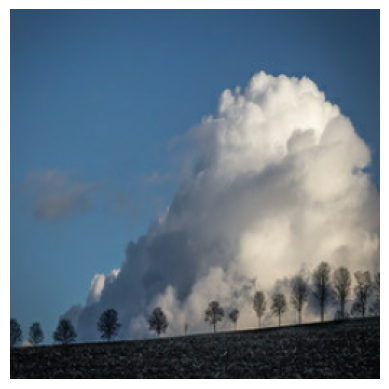

In [25]:
plot_image((random_photo_image[0]+1)/2)

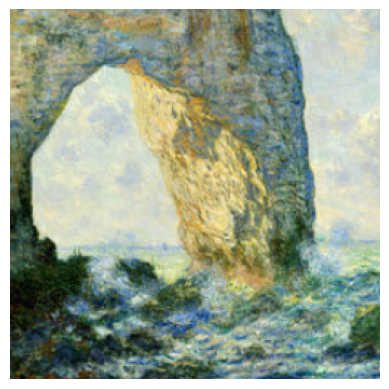

In [26]:
plot_image((random_monet_image[0]+1)/2)

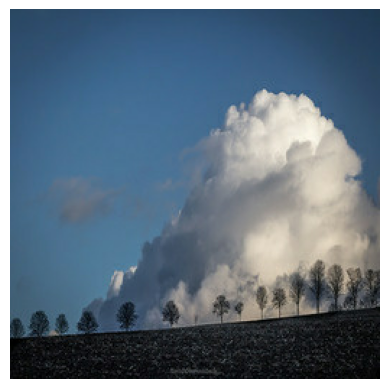

In [27]:
plot_image((random_photo_image_test[0]+1)/2)

In [28]:
del random_photo_image, random_monet_image, random_photo_image_test
gc.collect()

# gc 是 Python 标准库中的垃圾回收模块（gc 模块）。gc.collect() 函数强制运行垃圾回收，清理不再使用的对象，从而释放内存。
# 在调用 gc.collect() 后，Python 的垃圾回收机制会尽可能回收所有未使用的内存，进一步释放内存资源。

6534

# Model Training and Evalution

In [29]:
def diffaug_fn(image):
    return DiffAugment_tf.DiffAugment(image, "color,translation,cutout")

# Generator Discriminator

In [30]:
class InstanceNormalization(tf.keras.layers.Layer):
    '''
    __init__ 方法: 初始化层时设置 epsilon，这是一个小的常量，
    用于防止在计算标准差的平方根时除以零的问题
    '''
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    '''
    build 方法: 在创建层的权重时调用。input_shape 是输入数据的形状。
    self.scale: 这是一个可训练的缩放因子，初始化为一个正态分布的随机值（均值为1，标准差为0.02）。
    self.offset: 这是一个可训练的偏置因子，初始化为零
    '''
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.01),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
        
    '''
    call 方法: 执行实例归一化操作。
    tf.nn.moments(x, axes=[1, 2], keepdims=True): 计算输入 x 在高和宽维度上的均值和方差。
    tf.math.rsqrt(variance + self.epsilon): 计算标准差的倒数。self.epsilon 是一个小常数，用于防止方差为零。
    (x - mean) * inv: 标准化操作，将输入数据减去均值并乘以标准差的倒数。
    self.scale * normalized + self.offset: 将标准化后的数据乘以缩放因子，并加上偏置因子，得到最终的输出。
    '''
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset
    
#總結
#InstanceNormalization 层用于对图像进行实例归一化处理。
#它首先计算输入图像的均值和方差，然后进行归一化，最后通过可训练的缩放和偏置因子进行调整。
#这种归一化方式对每个样本独立地进行，有助于改善模型的训练稳定性和生成质量


# Create functions to construct the generator and discriminator.

In [31]:
# 下採樣
def downsample(filters, size, apply_instancenorm=True, add_noise=False):
    # filters 卷积层输出的过滤器数量（即通道数）
    # size 卷积核的尺寸（例如 3x3）
    # apply_instancenorm: 布尔值，表示是否应用实例归一化（Instance Normalization）。默认为 True。
    # add_noise: 布尔值，表示是否在卷积层后添加高斯噪声。默认为 False
    initializer = tf.random_normal_initializer(0., 0.01)
    #  用于初始化卷积核的权重。这里使用均值为 0，标准差为 0.01 的正态分布。
    result = keras.Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    # 卷积层: Conv2D 用于进行卷积操作，strides=2 表示每次卷积操作步幅为 2，从而实现下采样。padding='same' 确保卷积操作后图像尺寸不变。
    if add_noise:
        result.add(GaussianNoise(0.1))
    # 高斯噪声: 如果 add_noise 为 True，则添加高斯噪声，以增加模型的鲁棒性。
    if apply_instancenorm:
        result.add(InstanceNormalization())
    # 实例归一化: 如果 apply_instancenorm 为 True，则应用实例归一化层，有助于稳定训练过程。
    result.add(LeakyReLU()) 
    # 使用 LeakyReLU 激活函数以允许负值通过
    return result


# 上採樣
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.01)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

補充
在卷积神经网络（CNN）中，上采样（Upsampling）和下采样（Downsampling）是两种常见的操作，它们用于改变图像或特征图的空间尺寸（宽度和高度）。这两种操作有不同的目的和实现方式：

下采样（Downsampling）
目的:

减小特征图的空间尺寸。
增加特征图的感受野，提取更多的上下文信息。
通常用于降低计算复杂度和提高模型的计算效率。
常用方法:

卷积操作: 使用步幅大于1的卷积层。例如，Conv2D 层的 strides=2 表示每次卷积操作的步幅为2，从而减少特征图的尺寸。
最大池化（Max Pooling）: 通过选取池化窗口内的最大值来减少特征图的尺寸。例如，MaxPooling2D 层可以使用 2x2 的池化窗口来将特征图的尺寸减半。
平均池化（Average Pooling）: 与最大池化类似，但使用窗口内的平均值来减少尺寸。

效果:

特征图的宽度和高度减少，深度（通道数）通常增加。
有助于捕捉图像的高级特征，但可能丢失一些空间信息。


上采样（Upsampling）
目的:

增大特征图的空间尺寸。
恢复图像的空间分辨率，通常用于生成任务中，如图像生成和分割。
常用方法:

转置卷积（Transpose Convolution）: 通过转置卷积层（又称反卷积）来增加特征图的尺寸。例如，Conv2DTranspose 层可以使用步幅为2的转置卷积来将特征图的尺寸扩大一倍。
上采样（UpSampling）: 使用上采样操作，如 UpSampling2D，通过重复像素来增大特征图的尺寸。
插值方法: 使用插值算法（如最近邻插值、双线性插值）来增加图像的尺寸。
效果:

特征图的宽度和高度增加，深度（通道数）通常保持不变。
有助于恢复图像的细节和空间信息，通常用于图像重建或分割任务。

总结
下采样 减小特征图的尺寸，以捕捉更大的上下文信息并减少计算量。常用的方法包括卷积操作、池化层等。
上采样 增大特征图的尺寸，用于恢复图像的空间分辨率。常用的方法包括转置卷积、上采样层等。
下采样和上采样通常在网络的不同阶段使用。下采样用于提取高级特征并减少计算负担，而上采样用于恢复图像的细节或生成更高分辨率的图像。

下采样 就像是把大图画变小，看到的细节少了，但能更快了解大概的图案。

上采样 就像是把小图画变大，看到的细节多了，能更清楚地看到图案的细节。



In [32]:
# 生成器模型, 生成器的作用是生成新的图像，这些图像尽可能地类似于目标图像
def create_generator():
    # 寬度跟高度都是256,且有3個顏色通道(RGB)
    inputs = Input(shape=[256,256,3])
    output_channels = 3
    
    
    # 下採樣(編碼器)
    # 下采样层: 这部分通过一系列的卷积操作和最大池化操作逐步减小图像的尺寸，同时增加特征的数量。这样做的目的是提取图像的高层特征。
    # downsample 函数: 用于创建一个卷积层和（可选的）实例归一化层。每次下采样都会使图像的尺寸减半，并增加特征图的数量。
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]
    
    # 上採樣(解碼器)
    # 上采样层: 这部分通过一系列的反卷积操作（转置卷积）将图像的尺寸逐步放大，同时减少特征的数量。这样做的目的是将高层特征重新组合成与原始输入图像相同的尺寸。
    # upsample 函数: 用于创建一个转置卷积层（也叫上采样卷积层），可选的包含 dropout 层来防止过拟合。
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]
    
    # 最后的卷积层: 将图像的尺寸从（128, 128）扩大到（256, 256），输出的通道数是3（对应RGB图像），激活函数是 tanh，用于将像素值限制在 [-1, 1] 范围内。
    initializer = tf.random_normal_initializer(0., 0.01)
    last = Conv2DTranspose(output_channels, 4,
                           strides=2,
                           padding='same',
                           kernel_initializer=initializer,
                           activation='tanh') # (bs, 256, 256, 3)

    # 構建模型
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    outputs = last(x)
    return keras.Model(inputs=inputs, outputs=outputs)

#下采样阶段: 通过下采样层处理输入图像，并保存每一步的输出，用于后续的跳跃连接。

#跳跃连接: 在上采样过程中，将之前保存的特征图与当前的特征图连接起来，这样可以更好地保留图像的细节。

#最后的卷积层: 将特征图转换回图像大小，并生成最终的输出图像

In [34]:
# 判別器模型,这个判别器模型用于评估生成的图像是否看起来真实，并与真实图像进行比较，以训练生成对抗网络（GAN）
def create_discriminator(add_noise=True):
    # 初始化卷积核的权重，均值为0，标准差为0.02。
    initializer = tf.random_normal_initializer(0., 0.01)
    # 定义输入层，输入图像的大小为 256x256 像素，具有 3 个颜色通道（RGB）
    inputs = Input(shape=[256, 256, 3], name='input_image')
    x = inputs
    x = downsample(64, 4, False, add_noise=add_noise)(x) # (bs, 128, 128, 64)
    x = downsample(128, 4, add_noise=add_noise)(x) # (bs, 64, 64, 128)
    x = downsample(256, 4, add_noise=add_noise)(x) # (bs, 32, 32, 256)
    x = ZeroPadding2D()(x) # (bs, 34, 34, 256)
    x = Conv2D(512, 4, strides=1,
               kernel_initializer=initializer,
               use_bias=False)(x) # (bs, 31, 31, 512)
    if add_noise:
        x = GaussianNoise(0.2)(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU()(x)
    x = ZeroPadding2D()(x) # (bs, 33, 33, 512)
    outputs = Conv2D(1, 4, strides=1,
                     kernel_initializer=initializer)(x) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Model

In [35]:
class TrainingGAN(Model):
    def __init__(self, generator_g, discriminator_x, generator_f, discriminator_y,
                 lambda_loss=10, gamma_loss=1e-4, lambda_id_loss=1e-5, diffaug_fn=None, batch_size=32, **kwargs):
        super().__init__(**kwargs)
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y
        self.lambda_loss = lambda_loss
        self.gamma_loss = gamma_loss
        self.lambda_id_loss = lambda_id_loss
        self.diffaug_fn = diffaug_fn
        disc_inputs = Input(shape=[None, None, 3], name='input_image')
        self.discriminator_features_x = Model(inputs=self.discriminator_x.input,
                                              outputs=self.discriminator_x.layers[-2].output)
        self.discriminator_features_y = Model(inputs=self.discriminator_y.input,
                                              outputs=self.discriminator_y.layers[-2].output)

    def compile(self, generator_g_optimizer, discriminator_x_optimizer,
                generator_f_optimizer, discriminator_y_optimizer):
        super().compile()
        self.generator_g_optimizer = generator_g_optimizer
        self.discriminator_x_optimizer = discriminator_x_optimizer
        self.generator_f_optimizer = generator_f_optimizer
        self.discriminator_y_optimizer = discriminator_y_optimizer

    def _discriminator_bce_loss(self, real, generated):
        real_loss = BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        real_loss = tf.reduce_mean(real_loss)
        generated_loss = BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        generated_loss = tf.reduce_mean(generated_loss)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    def _generator_bce_loss(self, generated):
        loss = BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
        loss = tf.reduce_mean(loss)
        return loss

    def _cycle_loss(self, real_image, cycled_image):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return loss

    def _identity_loss(self, real_image, same_image):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return 0.5 * loss

    #@tf.function
    def train_step(self, batch):
        (real_x, real_y) = batch
        batch_size = tf.shape(real_y)[0]
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)
            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)
            same_x = self.generator_f(real_x, training=True)
            same_y = self.generator_g(real_y, training=True)

            if self.diffaug_fn:
                both_y = tf.concat([real_y, fake_y], axis=0)
                aug_y = self.diffaug_fn(both_y)
                aug_real_y = aug_y[:batch_size]
                aug_fake_y = aug_y[batch_size:]
                disc_real_y = self.discriminator_y(aug_real_y, training=True)
                disc_fake_y = self.discriminator_y(aug_fake_y, training=True)
            else:
                disc_real_y = self.discriminator_y(real_y, training=True)
                disc_fake_y = self.discriminator_y(fake_y, training=True)

            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_fake_x = self.discriminator_x(fake_x, training=True)

            disc_feat_x = self.discriminator_features_x(real_x, training=True)
            disc_feat_cycled_x = self.discriminator_features_x(cycled_x, training=True)
            disc_feat_y = self.discriminator_features_x(real_y, training=True)
            disc_feat_cycled_y = self.discriminator_features_x(cycled_y, training=True)

            gen_g_loss = self._generator_bce_loss(disc_fake_y)
            gen_f_loss = self._generator_bce_loss(disc_fake_x)
            cycle_loss_x = ((1 - self.gamma_loss) * self._cycle_loss(real_x, cycled_x) +
                            self.gamma_loss * self._cycle_loss(disc_feat_x, disc_feat_cycled_x))
            cycle_loss_y = ((1 - self.gamma_loss) *  self._cycle_loss(real_y, cycled_y) +
                            self.gamma_loss * self._cycle_loss(disc_feat_y, disc_feat_cycled_y))
            total_cycle_loss = self.lambda_loss * (cycle_loss_x + cycle_loss_y)
            id_loss_y = self.lambda_id_loss * self._identity_loss(real_y, same_y)
            id_loss_x = self.lambda_id_loss * self._identity_loss(real_x, same_x)
            total_gen_g_loss = gen_g_loss + total_cycle_loss + id_loss_y
            total_gen_f_loss = gen_f_loss + total_cycle_loss + id_loss_x

            disc_x_loss = self._discriminator_bce_loss(disc_real_x, disc_fake_x)
            disc_y_loss = self._discriminator_bce_loss(disc_real_y, disc_fake_y)

        generator_g_gradients = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)
        discriminator_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        self.generator_g_optimizer.apply_gradients(zip(generator_g_gradients, self.generator_g.trainable_variables))
        self.generator_f_optimizer.apply_gradients(zip(generator_f_gradients, self.generator_f.trainable_variables))
        self.discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, self.discriminator_x.trainable_variables))
        self.discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, self.discriminator_y.trainable_variables))

        return {
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss,
            "total_gen_g_loss": total_gen_g_loss,
            "total_gen_f_loss": total_gen_f_loss,
            "gen_g_loss": cycle_loss_x,
            "gen_f_loss": cycle_loss_y,
            }

# Callbacks

#建立一個訓練回調，在每個訓練紀元間隔輸出輸入和預測影像

In [36]:
class PlotPredictionsCallback(keras.callbacks.Callback):
    def __init__(self, input_image, model_generator, epoch_interval=5, nrows=1, figsize=(11, 11)):
        '''
        input_image: 传入的测试图像或验证图像，用于生成预测。
        model_generator: 生成预测结果的模型，通常是GAN的生成器。
        epoch_interval: 每隔多少个epoch进行一次绘图，如果设置为None，则只在训练结束时绘图。
        nrows: 图像展示的行数。
        figsize: 图像展示的大小。
        '''
        self.input_image = input_image
        self.model_generator = model_generator
        self.epoch_interval = epoch_interval
        self.nrows = nrows
        self.figsize=(11, 11)

    def _plot_test_and_pred(self):
        '''
        功能：该方法生成预测图像并展示与输入图像的对比。
        predict: 使用模型对传入的input_image进行预测，生成预测图像。
        subplots: 创建一个包含输入图像和预测图像的图形网格。
        imshow: 用来显示图像。
        set_title: 为图像设置标题，标注是输入图像还是预测图像。
        set_axis_off: 隐藏坐标轴以便更好地展示图像。
        '''
        preds = self.model_generator.predict(self.input_image, verbose=0)
        (fig, axes) = subplots(nrows=self.nrows, ncols=2, figsize=self.figsize)
        if self.nrows == 1:
            axes = [axes]
        for (ax, inp, pred) in zip(axes, self.input_image, preds):
            ax[0].imshow(array_to_img(inp))
            ax[0].set_title("Input Image")
            ax[0].set_axis_off()
            ax[1].imshow(array_to_img(pred))
            ax[1].set_title("Prediction")
            ax[1].set_axis_off()
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        '''
        功能：每个epoch结束时调用，如果设置了epoch_interval并且当前epoch是epoch_interval的倍数，则调用_plot_test_and_pred方法进行绘图。
        '''
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            self._plot_test_and_pred()

    def on_train_end(self, logs=None):
        '''
        功能：在整个训练结束时调用_plot_test_and_pred方法，展示最终的预测结果。
        '''
        self._plot_test_and_pred()

下一個回調更新每個模型優化器的學習率

In [37]:
class UpdateLearningRateCallback(Callback):
    '''
    是一个自定义的 Keras 回调类，用于在模型训练过程中动态调整生成器和判别器的学习率
    '''
    def __init__(self, epochs_count, lr_start=2e-4, lr_end=5e-6):
        '''
        初始化回调对象，定义了起始学习率 lr_start 和结束学习率 lr_end。它根据总训练轮数 epochs_count 计算出学习率开始更新的轮次 epoch_min 以及从哪一轮开始更新学习率的序列 lr_values。
        '''
        
        super().__init__()
        self.epoch_min = epochs_count // 2
        epochs_update_count = epochs_count - self.epoch_min
        self.lr_values = np.linspace(lr_start, lr_end, epochs_update_count)

    def _scheduler_fn(self, epoch, lr):
        '''
        这是一个内部函数，用于计算当前的学习率。当训练轮次 epoch 小于 epoch_min（即总训练轮次的一半）时，保持当前学习率不变；当 epoch 大于等于 epoch_min 时，使用预先计算好的 lr_values 进行学习率的更新。
        '''
        if epoch < self.epoch_min:
            return lr
        else:
            return self.lr_values[epoch-self.epoch_min]

    def on_epoch_begin(self, epoch, logs=None):
        '''
        在每个训练轮次开始时调用。此方法根据 _scheduler_fn 计算出的学习率来更新模型中生成器和判别器的学习率。
        '''
        self.model.generator_g_optimizer.learning_rate = self._scheduler_fn(epoch, self.model.generator_g_optimizer.learning_rate)
        self.model.discriminator_x_optimizer.learning_rate = self._scheduler_fn(epoch, self.model.generator_g_optimizer.learning_rate)
        self.model.generator_f_optimizer.learning_rate = self._scheduler_fn(epoch, self.model.generator_g_optimizer.learning_rate)
        self.model.discriminator_y_optimizer.learning_rate = self._scheduler_fn(epoch, self.model.generator_g_optimizer.learning_rate)

下面的回調透過在訓練期間更新 lambda 和 gamma 權重來實現論文 Cy​​cleGAN 與 Better Cycles 的主要概念之一

In [38]:
class UpdateLossWeightsCallback(Callback):
    '''
    用于在模型训练过程中动态调整损失函数中的权重参数
    '''
    
    def __init__(self, epochs, lambda_start=10, lambda_end=1e-4, gamma_start=1e-4, gamma_end=0.999):
        '''
        定义了训练轮数 epochs，以及损失权重 lambda_loss 和 gamma_loss 的起始值和结束值。
        lambda_start 和 lambda_end 对应的是 lambda_loss 的变化范围，而 gamma_start 和 gamma_end 对应的是 gamma_loss 的变化范围。
        '''
        super().__init__()
        self.epochs = epochs
        self.lambda_start = lambda_start
        self.lambda_end = lambda_end
        self.gamma_start = gamma_start
        self.gamma_end = gamma_end

    def on_train_begin(self, logs=None):
        '''
        在训练开始时调用。
        该方法根据总训练轮数 epochs，计算出从 lambda_start 到 lambda_end 和从 gamma_start 到 gamma_end 的线性插值序列 lambda_values 和 gamma_values，
        这些序列将用于训练过程中逐步更新模型的损失权重。
        '''
        self.lambda_values = np.linspace(self.lambda_start, self.lambda_end, self.epochs)
        self.gamma_values = np.linspace(self.gamma_start, self.gamma_end, self.epochs)

    def on_epoch_begin(self, epoch, logs=None):
        '''
        在每个训练轮次开始时调用。此方法将当前 epoch 对应的 lambda_values 和 gamma_values 分别赋值给模型的 lambda_loss 和 gamma_loss，
        从而在训练过程中动态调整损失函数中的权重参数。
        '''
        self.model.lambda_loss = self.lambda_values[epoch]
        self.model.gamma_loss = self.gamma_values[epoch]

# Object for training

In [39]:
EPOCHS = 40
STEPS_PER_EPOCH = 3000
LAMBDA_START = 3
LAMBDA_END = 1e-4
GAMMA_START = 1e-4
GAMMA_END = 0.999
LAMBDA_ID = 1e-4
EPOCH_INTERVAL_PLOT = 5
#EPOCH_INTERVAL_FID = None
LR_START = 2e-4
LR_END = 5e-6

In [40]:
#if True:
with strategy.scope():
    update_lr_cb = UpdateLearningRateCallback(EPOCHS, lr_start=LR_START, lr_end=LR_END)

In [41]:
#if True:
with strategy.scope():
    generator_g = create_generator()
    generator_f = create_generator()
    discriminator_x = create_discriminator(add_noise=True)
    discriminator_y = create_discriminator(add_noise=True)

In [42]:
generator_g.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,328 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    524,800 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,098,176 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,195,328 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,195,328 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,195,328 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,195,328 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,195,328 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,389,632 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,389,632 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,389,632 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,414,979 (207.58 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
discriminator_x.summary()

In [43]:
with strategy.scope():
    plot_pred_photo = next(iter(test_photo_ds.take(1)))  # 从测试数据集中获取一个批次的数据。  
    plot_pred_photo = np.expand_dims(plot_pred_photo[0], axis=0) # 获取这个批次中的数据，plot_pred_photo[0] 是数据批次中的图像数据。  在数据的开头添加一个新的维度，变成（batch_size, height, width, channels），以符合模型的输入要求。

    plot_pred_cb = PlotPredictionsCallback(
                                      input_image=plot_pred_photo,  #  设置用于生成图像的输入数据
                                      model_generator=generator_g,  #  传入用于生成图像的生成器模型
                                      epoch_interval=EPOCH_INTERVAL_PLOT) # 设置回调函数的触发间隔，即每隔多少个 epoch 生成一次图像预测结果。

In [44]:
with strategy.scope():
    update_weights_cb = UpdateLossWeightsCallback(
                                                EPOCHS,
                                                lambda_start=LAMBDA_START,
                                                lambda_end=LAMBDA_END,
                                                gamma_start=GAMMA_START,
                                                gamma_end=GAMMA_END)

# Training

In [45]:
with strategy.scope():
    model_cycleGAN = TrainingGAN(
                                generator_g=generator_g,
                                generator_f=generator_f,
                                discriminator_x=discriminator_x,
                                discriminator_y=discriminator_y,
                                lambda_loss=LAMBDA_START,
                                lambda_id_loss=LAMBDA_ID,
                                gamma_loss=GAMMA_START,
                                diffaug_fn=diffaug_fn)
    
    generator_g_optimizer = Adam(learning_rate=LR_START, beta_1=0.5)
    discriminator_x_optimizer = Adam(learning_rate=LR_START, beta_1=0.5)
    generator_f_optimizer = Adam(learning_rate=LR_START, beta_1=0.5)
    discriminator_y_optimizer = Adam(learning_rate=LR_START, beta_1=0.5)

    model_cycleGAN.compile(
                        generator_g_optimizer=generator_g_optimizer,
                        discriminator_x_optimizer=discriminator_x_optimizer,
                        generator_f_optimizer=generator_f_optimizer,
                        discriminator_y_optimizer=discriminator_y_optimizer)

In [46]:
%%time
model_cycleGAN.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[plot_pred_cb, update_weights_cb, update_lr_cb],
    steps_per_epoch=STEPS_PER_EPOCH
)

Epoch 1/40


2024-08-20 09:09:37.762388: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_746/cond/StatefulPartitionedCall/functional_15_1/sequential_8_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 217/3000 ━━━━━━━━━━━━━━━━━━━━ 25:14 544ms/step - disc_x_loss: 0.7036 - disc_y_loss: 0.7097 - gen_f_loss: 0.2528 - gen_g_loss: 0.2859 - total_gen_f_loss: 2.3484 - total_gen_g_loss: 2.3268

KeyboardInterrupt: 

# Plot predictions

In [ ]:
def plot_predictions(model, ds):
    ds_iter = iter(ds)
    for n_sample in range(8):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample, verbose=0)
        f = plt.figure(figsize=(13, 13))
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

In [ ]:
plot_predictions(generator_g, test_photo_ds.shuffle(1000))

# Submission

In [ ]:
def generate_and_save(generator, ds):
    count = 0
    if os.path.exists('images.zip'):
        os.remove('images.zip')
    with zipfile.ZipFile('images.zip', 'w') as zipf:
        for images_batch in ds:
            predictions = generator(images_batch, training=False)
            for pred in predictions:
                count += 1
                generated_image = array_to_img(pred)
                generated_image_bytes = BytesIO()
                generated_image.save(generated_image_bytes, format='JPEG')
                generated_image_bytes.seek(0)
                zipf.writestr(f'generated_image_{count}.jpg', generated_image_bytes.getvalue())
                if count % 1024 == 0:
                    print(f'Archived images: {count}')

In [ ]:
%%time
generate_and_save(generator_g, test_photo_ds)